In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
from eofs.xarray import Eof
import tensorflow as tf
import gpflow
import seaborn as sns
import cartopy.crs as ccrs
from utils import *

# import from parent level
import sys 
sys.path.append('..')
from path_parameters import TRAIN_PATH, TEST_PATH, OUTPUT_PATH

2022-04-05 09:20:07.859142: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-05 09:20:07.859166: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
data_path = TRAIN_PATH
test_path = TEST_PATH
output_path = OUTPUT_PATH

### Prepare data

In [3]:
# List of dataset to use for training
train_files = ["ssp126", "ssp585", "historical", "hist-GHG"]

In [4]:
# Create training and testing arrays
X_train = pd.concat([create_predictor_data([file])[0] for file in train_files])
y_train_pr90 = np.vstack([create_predictdand_data([file])['pr90'].values.reshape(-1, 96 * 144)
                         for file in train_files])

X_test, _ = create_predictor_data(['ssp245'], test=True)
Y_test = xr.open_dataset(test_path + 'outputs_ssp245.nc').compute()
pr90_truth = 86400 * Y_test["pr90"].mean('member')

/home/julia/anaconda3/envs/climatebench01/lib/python3.7/site-packages/eofs/standard.py:272: RuntimeWarning: invalid value encountered in true_divide
  return self._P[:, slicer] / np.sqrt(self._L[slicer])


In [5]:
# Drop rows including nans
nan_train_mask = X_train.isna().any(axis=1).values
X_train = X_train.dropna(axis=0, how='any')
y_train_pr90 = y_train_pr90[~nan_train_mask]
assert len(X_train) == len(y_train_pr90)

nan_test_mask = X_test.isna().any(axis=1).values
X_test = X_test.dropna(axis=0, how='any')
pr90_truth = pr90_truth[~nan_test_mask]

In [6]:
# Standardize predictor fields requiring standardization (non-EOFs)
train_CO2_mean, train_CO2_std = X_train['CO2'].mean(), X_train['CO2'].std()
train_CH4_mean, train_CH4_std = X_train['CH4'].mean(), X_train['CH4'].std()

X_train.CO2 = (X_train.CO2 - train_CO2_mean) / train_CO2_std
X_train.CH4 = (X_train.CH4 - train_CH4_mean) / train_CH4_std

X_test.CO2 = (X_test.CO2 - train_CO2_mean) / train_CO2_std
X_test.CH4 = (X_test.CH4 - train_CH4_mean) / train_CH4_std

In [7]:
# Standardize predictand fields
train_pr90_mean, train_pr90_std = y_train_pr90.mean(), y_train_pr90.std()
y_train_pr90 = (y_train_pr90 - train_pr90_mean) / train_pr90_std

### Prepare model

In [8]:
# Make kernel
kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0])
kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])

kernel_BC = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[2, 3, 4, 5, 6])
kernel_SO2 = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[7, 8, 9, 10, 11])

kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2

2022-04-05 09:20:20.504554: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-05 09:20:20.504584: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-05 09:20:20.504602: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Rivendell): /proc/driver/nvidia/version does not exist
2022-04-05 09:20:20.504872: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# Make model
np.random.seed(5)
mean = gpflow.mean_functions.Constant()
model = gpflow.models.GPR(data=(X_train.astype(np.float64), 
                                y_train_pr90.astype(np.float64)),
                          kernel=kernel,
                          mean_function=mean)

In [10]:
# Define optimizer
opt = gpflow.optimizers.Scipy()

# Train model
opt.minimize(model.training_loss,
             variables=model.trainable_variables,
             options=dict(disp=True, maxiter=1000))

2022-04-05 09:20:22.923732: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.03950D+06    |proj g|=  2.70413D+05


 This problem is unconstrained.



At iterate    1    f=  6.92399D+06    |proj g|=  3.65264D+05

At iterate    2    f=  6.84194D+06    |proj g|=  1.17730D+05

At iterate    3    f=  6.75410D+06    |proj g|=  1.08282D+05

At iterate    4    f=  6.48229D+06    |proj g|=  2.64265D+05

At iterate    5    f=  6.41532D+06    |proj g|=  1.52498D+05

At iterate    6    f=  6.36988D+06    |proj g|=  8.65334D+04

At iterate    7    f=  6.35870D+06    |proj g|=  4.37856D+04

At iterate    8    f=  6.34225D+06    |proj g|=  1.09021D+04

At iterate    9    f=  6.33376D+06    |proj g|=  1.17331D+04

At iterate   10    f=  6.32889D+06    |proj g|=  3.15026D+03

At iterate   11    f=  6.32799D+06    |proj g|=  1.77547D+03

At iterate   12    f=  6.32763D+06    |proj g|=  2.28641D+03

At iterate   13    f=  6.32749D+06    |proj g|=  7.09883D+02

At iterate   14    f=  6.32746D+06    |proj g|=  5.74884D+02

At iterate   15    f=  6.32741D+06    |proj g|=  6.71249D+02

At iterate   16    f=  6.32730D+06    |proj g|=  9.56735D+02

At iter

      fun: 6325864.454117037
 hess_inv: <18x18 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.20791559e-01,  3.43840128e+00, -1.07506136e-01,  1.33289146e+00,
       -2.52336869e-09,  3.78959068e-09, -1.44463654e-09, -1.76835512e-09,
       -6.65104620e-10,  1.05820231e-08, -5.38387929e-11, -1.50400461e-10,
       -3.46488457e-11, -1.65763170e-11,  1.80100653e-12,  9.54220394e-10,
        1.24264879e+01,  1.01929921e+00])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 54
      nit: 41
     njev: 54
   status: 0
  success: True
        x: array([  0.21323651,  -1.45943323,  12.81979943,  -1.66052441,
         2.91722755,   2.76140707,   4.95373824,   3.32494665,
         4.64044049, -29.24145185,   2.59738096,   1.41669263,
         3.20374521,   5.26267531,   5.34594158, -32.99652867,
         0.28259155,   0.056096  ])


At iterate   41    f=  6.32586D+06    |proj g|=  1.24265D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     41     54      1     0     0   1.243D+01   6.326D+06
  F =   6325864.4541170374     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


### Predict on testing set

In [11]:
# predict
standard_posterior_mean, standard_posterior_var = model.predict_y(X_test.values)
posterior_mean = standard_posterior_mean * train_pr90_std + train_pr90_mean
posterior_std = np.sqrt(standard_posterior_var) * train_pr90_std

In [12]:
# put output back into xarray format for calculating RMSE/plotting
posterior_pr90 = np.reshape(posterior_mean, [86, 96, 144])
posterior_pr90_std = np.reshape(posterior_std, [86, 96, 144])
posterior_pr90_data = xr.DataArray(posterior_pr90, dims=pr90_truth.dims, coords=pr90_truth.coords)
posterior_pr90_std_data = xr.DataArray(posterior_pr90_std, dims=pr90_truth.dims, coords=pr90_truth.coords)

In [13]:
# Compute RMSEs
print(f"RMSE at 2050: {get_rmse(pr90_truth[35], posterior_pr90_data[35])}")
print(f"RMSE at 2100: {get_rmse(pr90_truth[85], posterior_pr90_data[85])}")
print(f"RMSE 2045-2055: {get_rmse(pr90_truth[30:41], posterior_pr90_data[30:41]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(pr90_truth[75:], posterior_pr90_data[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(pr90_truth[35:], posterior_pr90_data[35:]).mean()}")

RMSE at 2050: 1.3987481313242531
RMSE at 2100: 1.6116506701259317
RMSE 2045-2055: 1.523850422509571
RMSE 2090-2100: 1.572803160786428
RMSE 2050-2100: 1.5609705570601402


[Text(0.5, 1.0, 'Difference')]

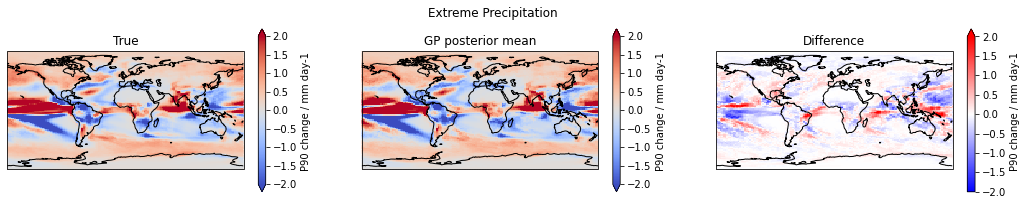

In [14]:
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Extreme Precipitation')

# Test
plt.subplot(131, projection=proj)
pr90_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", vmin=-2,
                              cbar_kwargs={"label":"P90 change / mm day-1 "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
posterior_pr90_data.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", vmin=-2,
                              cbar_kwargs={"label":"P90 change / mm day-1 "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='GP posterior mean')

# Difference
difference = pr90_truth - posterior_pr90_data
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"P90 change / mm day-1 "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

__Feature importance__
- CO2 (0.48)
- SO2 (1.20)
- Significant internal variability (0.46)

In [15]:
model

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.c,Parameter,Identity,,True,"(1,)",float64,[0.056096]
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.20893747106364136
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.8054384245690215
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.17398632722393745
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,12.819802137789303
GPR.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,1.9980153345101385e-13
GPR.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[2.96989914, 2.8226929, 4.96077044..."
GPR.kernel.kernels[3].variance,Parameter,Softplus,,True,(),float64,4.675086791532852e-15
GPR.kernel.kernels[3].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[2.66920695, 1.63383, 3.24355212..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.8443931661894507


In [16]:
# Save predictions
posterior_pr90_data.to_netcdf(output_path + 'climatebench-gp-posterior-mean-pr90-test-2019-2100.nc')
posterior_pr90_std_data.to_netcdf(output_path + 'climatebench-gp-posterior-std-pr90-test-2019-2100.nc')